In [1]:
import numpy as np
import tensorflow as tf

import cv2, os, glob, random, argparse,tqdm
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import imgaug.augmenters as iaa
import imgaug as ia

from tensorflow import keras
from tensorflow.keras import callbacks
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import *
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, BatchNormalization, Activation, add, concatenate

# parsing args                                                                                                                                              
# parser = argparse.ArgumentParser(description= 'Unet_training')

In [2]:
ramdom_seed = 5198
input_h = 256
input_w = 256
input_c = 3
data_path = 'data_stomach'
batch_size = 32
file_save_name = 'save_model_stomach_Unet'
epochs = 200
validation_steps = 16
mse_w = 1
ssim_w = 10
lr = 0.0002
# random seed and gpu allow

physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

tf.random.set_seed(ramdom_seed)
np.random.seed(ramdom_seed)
random.seed(ramdom_seed)
os.environ['PYTHONHASHSEED'] = str(ramdom_seed)

In [3]:
# loss 

def mse_dssim(y_true, y_pred):
    return mse_w * tf.losses.mean_squared_error(y_true, y_pred) + ssim_w *(1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val = 1)))

# model 
def bn_act(x, act=True):
    x = keras.layers.BatchNormalization()(x)
    if act == True:
        x = keras.layers.Activation("relu")(x)
    return x

def conv_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    conv = bn_act(x)
    conv = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(conv)
    return conv

def stem(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    conv = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(x)
    conv = conv_block(conv, filters, kernel_size=kernel_size, padding=padding, strides=strides)
    
    shortcut = keras.layers.Conv2D(filters, kernel_size=(1, 1), padding=padding, strides=strides)(x)
    shortcut = bn_act(shortcut, act=False)
    
    output = keras.layers.Add()([conv, shortcut])
    return output

def residual_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    res = conv_block(x, filters, kernel_size=kernel_size, padding=padding, strides=strides)
    res = conv_block(res, filters, kernel_size=kernel_size, padding=padding, strides=1)
    
    shortcut = keras.layers.Conv2D(filters, kernel_size=(1, 1), padding=padding, strides=strides)(x)
    shortcut = bn_act(shortcut, act=False)
    
    output = keras.layers.Add()([shortcut, res])
    return output

def upsample_concat_block(x, xskip):
    u = keras.layers.UpSampling2D((2, 2))(x)
    c = keras.layers.Concatenate()([u, xskip])
    return c


def ResUNet(image_size):
    f = [16, 32, 64, 128, 256]
    inputs = keras.layers.Input((image_size, image_size, 3))
    
    ## Encoder
    e0 = inputs
    e1 = stem(e0, f[0])
    e2 = residual_block(e1, f[1], strides=2)
    e3 = residual_block(e2, f[2], strides=2)
    e4 = residual_block(e3, f[3], strides=2)
    e5 = residual_block(e4, f[4], strides=2)
    
    ## Bridge
    b0 = conv_block(e5, f[4], strides=1)
    b1 = conv_block(b0, f[4], strides=1)
    
    ## Decoder
    u1 = upsample_concat_block(b1, e4)
    d1 = residual_block(u1, f[4])
    
    u2 = upsample_concat_block(d1, e3)
    d2 = residual_block(u2, f[3])
    
    u3 = upsample_concat_block(d2, e2)
    d3 = residual_block(u3, f[2])
    
    u4 = upsample_concat_block(d3, e1)
    d4 = residual_block(u4, f[1])
    
    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(d4)
    model = keras.models.Model(inputs, outputs)
    return model

model = ResUNet(input_h)

model.compile(optimizer = keras.optimizers.Adam(lr = lr), loss = mse_dssim)


In [4]:
def load_seq_data(path):
    imgs = []
    labs = []
    frame_image_paths = sorted(glob.glob(path + '/*/trans3/*.png'))
    frame_depth_paths = sorted(glob.glob(path + '/*/depth/*.png'))
    # print(frame_image_paths)
    for i in tqdm.tqdm(range(len(frame_image_paths))):
        img = cv2.cvtColor(cv2.imread(frame_image_paths[i]), cv2.COLOR_BGR2RGB)
        depth = cv2.cvtColor(cv2.imread(frame_depth_paths[i]), cv2.COLOR_BGR2GRAY)
        imgs.append(img)
        labs.append(depth)
    return np.array(imgs), np.array(labs)


In [5]:
path = r'D:\DATA\ENDOSCOPY\00_vrcaps_recoding_data_simulation\20210624\train'
train_data, train_lab = load_seq_data(path)
path = r'D:\DATA\ENDOSCOPY\00_vrcaps_recoding_data_simulation\20210624\val'
val_data, val_lab = load_seq_data(path)


100%|██████████| 1425/1425 [00:15<00:00, 89.40it/s]


In [6]:
train_data.shape

(13965, 256, 256, 3)

In [7]:
def image_aug_batch(img, label):
    # images = h w c
    # label bbox = (left, top, right, bottom)
    seq = iaa.Sequential([
    iaa.Multiply((0.9, 1.1)),
    iaa.Affine(
        translate_px={"x": 10, "y": 10},
        scale=(0.95, 1.05),
        rotate=(-180, 180)),
    iaa.Fliplr(0.5),
    iaa.Flipud(0.5)
    ])
    images_aug, labels_aug = seq(images = img.astype(np.float32)/255. ,heatmaps = label.astype(np.float32)/255.)
    return images_aug, labels_aug

def data_generator(train_imgs, train_labels, batch_size, aug = True):
    idx = 0
    while 1:
        idx_list = list(range(0,len(train_imgs)))
        random.shuffle(idx_list)
        if idx > len(idx_list) - batch_size:
            tmp_list = idx_list[idx:]
            idx = 0
        else:
            tmp_list = idx_list[idx:idx + batch_size]
            idx = idx + batch_size
        batch_images = train_imgs[tmp_list]
        batch_labels = train_labels[tmp_list]
        
        if aug == True:
            batch_images, batch_labels = image_aug_batch(batch_images, batch_labels)
        else:
            batch_images, batch_labels = batch_images / 255., batch_labels / 255.
        yield batch_images, batch_labels
        
train_gen = data_generator(train_data, train_lab[..., np.newaxis], batch_size, aug = True)
# test_gen = data_generator(test_x, test_y, batch_size, aug = False)
val_gen = data_generator(val_data, val_lab[..., np.newaxis], batch_size, aug = False)

In [8]:
print('steps :', int(len(train_data)/batch_size))
# print('val step epochs :', int(len(val_x)/batch_size))

try:
    if not os.path.exists(file_save_name):
        os.makedirs(file_save_name)
except OSError:
    print ('Error: Creating directory. ' +  file_save_name)
    
filepath = f'{file_save_name}' + '/model-{epoch:04d}.h5'
checkpoint = ModelCheckpoint(filepath, save_weights_only=True)

model_hist = model.fit(train_gen, validation_data= val_gen, validation_steps = int(len(val_data)/batch_size),  epochs = 100, steps_per_epoch =  int(len(train_data)/batch_size),
                    callbacks = [checkpoint])

steps : 436
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 436 steps, validate for 44 steps
Epoch 1/100
436/436 [==============================] - 167s 382ms/step - loss: 0.6754 - val_loss: 0.4709
Epoch 2/100
436/436 [==============================] - 162s 371ms/step - loss: 0.1962 - val_loss: 0.2298
Epoch 3/100
436/436 [==============================] - 159s 364ms/step - loss: 0.1562 - val_loss: 0.2732
Epoch 4/100
436/436 [==============================] - 159s 365ms/step - loss: 0.1368 - val_loss: 0.2109
Epoch 5/100
436/436 [==============================] - 159s 365ms/step - loss: 0.1248 - val_loss: 0.2856
Epoch 6/100
436/436 [==============================] - 159s 365ms/step - loss: 0.1125 - val_loss: 0.1974
Epoch 7/100
436/436 [==============================] - 159s 366ms/step - loss: 0.1084 - val_loss: 0.2018
Epoch 8/100
436/436 [==============================] - 171s 392ms/step - loss: 0.1039 - val_loss: 0.1675
Epoch 9/100
436/436 [==============================] - 

KeyboardInterrupt: 

In [9]:
path_real = r'D:\DATA\ENDOSCOPY\yonsei\normal_crop'

In [10]:
def load_data(path):
    all_data = []
    data_list = glob.glob(path + '/*.png')[-50:]
    # print(data_list)
    for tmp in data_list: 
        img = cv2.imread(tmp)
        img = cv2.cvtColor(cv2.resize(img, (256,256)), cv2.COLOR_BGR2RGB)
        all_data.append(img)
    all_data = np.array(all_data)/255.
    return all_data

In [34]:
model.load_weights('save_model_stomach_Unet/model-0100.h5')

In [11]:
all_img = load_data(path_real)
predict_imgs = model.predict(all_img)

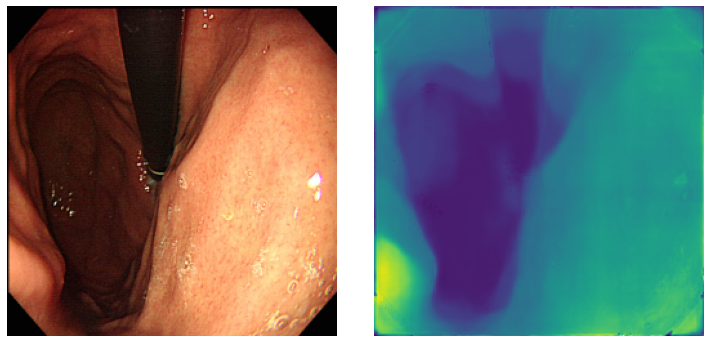

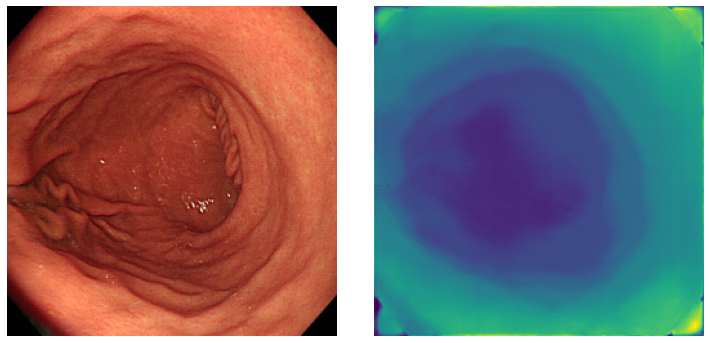

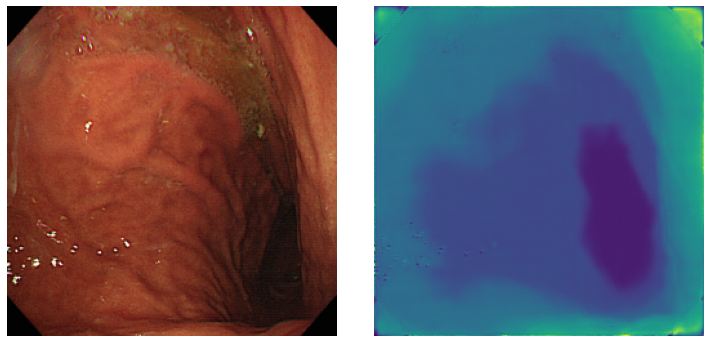

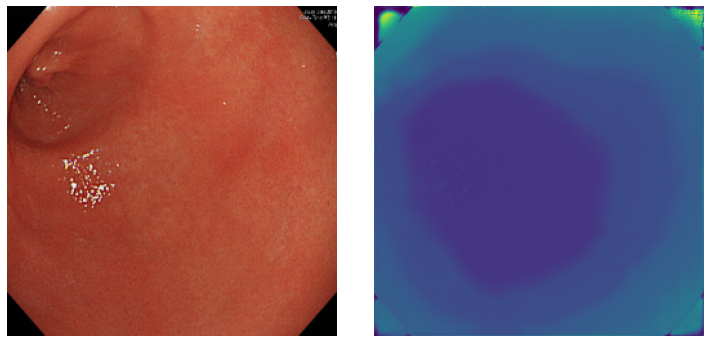

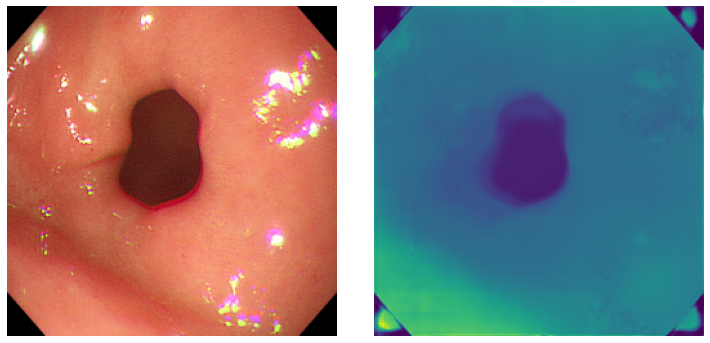

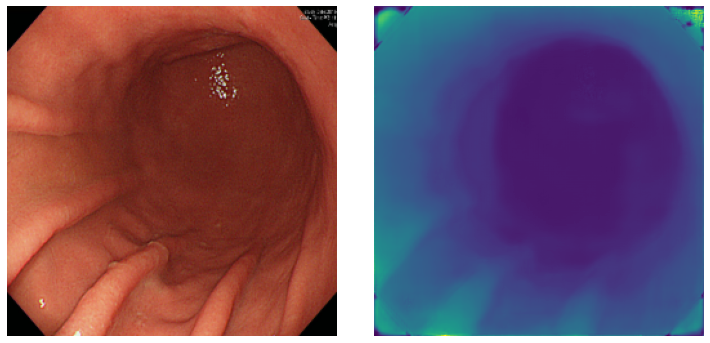

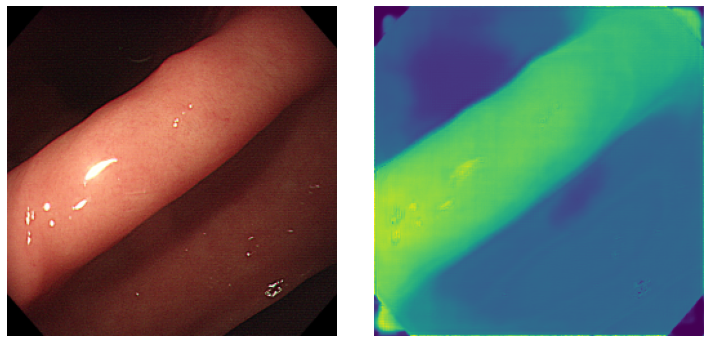

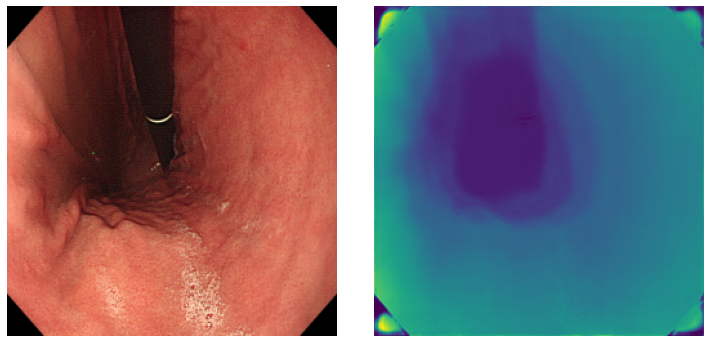

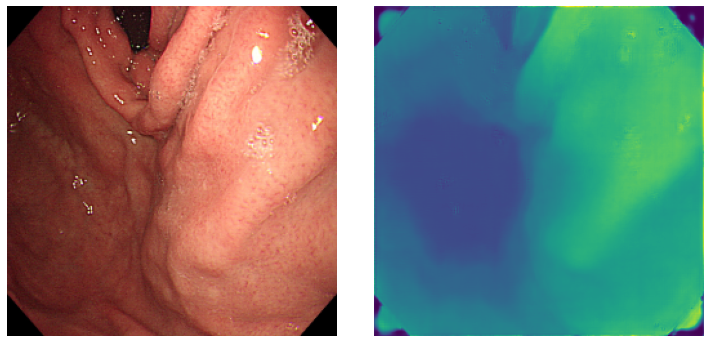

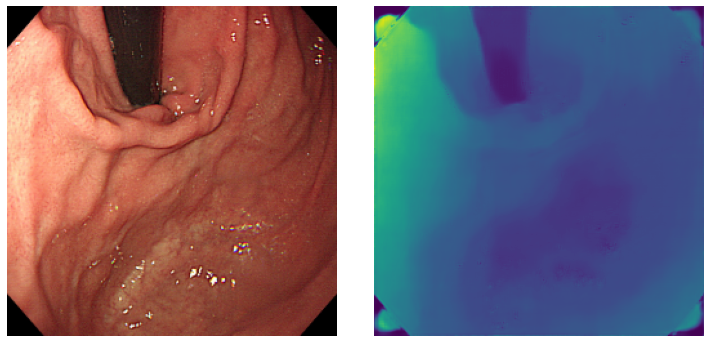

In [12]:
for i in range(30,40):
    plt.figure(figsize=(10, 10))
    plt.subplot(121)
    plt.imshow(all_img[i])
    plt.tight_layout()
    plt.axis('off')
    plt.subplot(122)
    plt.imshow(predict_imgs[i,...,0])
    plt.tight_layout()
    plt.axis('off')

    plt.show()

In [5]:
test_x = np.load(os.path.join('data_sim', 'eval.npy'))
test_y = np.load(os.path.join('data', 'test_y.npy'))

In [6]:
predict_imgs = model.predict(test_x/255.)

In [7]:
def img_decode(batch_images):
    batch_images = (batch_images * 255).astype(np.uint8)
    return np.clip(batch_images, 0, 255)

In [8]:
cm = plt.get_cmap('magma')

for i in range(len(predict_imgs)):
    colored_image = cm(predict_imgs[i,...,0])
    colored_image = img_decode(colored_image[...,:3])
    cv2.imwrite(os.path.join('00_inference/simulation',f'{i:04d}.png'), cv2.cvtColor(colored_image, cv2.COLOR_BGR2RGB))

In [10]:
test_x = np.load(os.path.join('data_sim', 'eval_x.npy'))
predict_imgs = model.predict(test_x/255.)

cm = plt.get_cmap('magma')

for i in range(len(predict_imgs)):
    colored_image = cm(predict_imgs[i,...,0])
    colored_image = img_decode(colored_image[...,:3])
    cv2.imwrite(os.path.join('00_inference_real/simulation',f'{i:04d}.png'), cv2.cvtColor(colored_image, cv2.COLOR_BGR2RGB))

In [5]:
data_path = '../cyclegan_stomach/images/B/'

In [28]:
def load_data(path):
    all_data = []
    data_list = glob.glob(path + '/*.png')
    for tmp in data_list: 
        img = cv2.imread(tmp)
        img = cv2.cvtColor(cv2.resize(img, (256,256)), cv2.COLOR_BGR2RGB)
        all_data.append(img)
    all_data = np.array(all_data)/255.
    return all_data

In [33]:
all_img = load_data(data_path)

In [39]:
model.load_weights('save_model/model-0100.h5')

In [40]:
predict_imgs = model.predict(all_img)

In [42]:
random.randint(0, 3000)

9

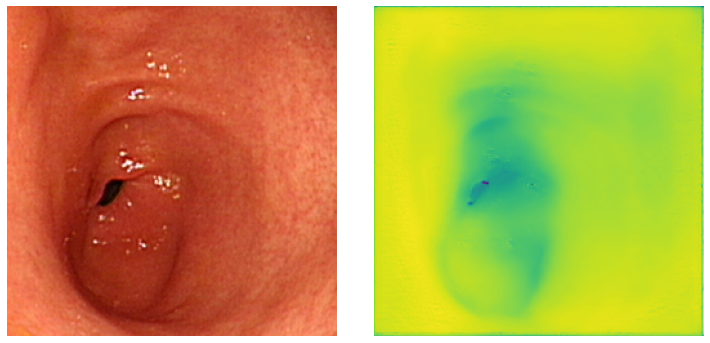

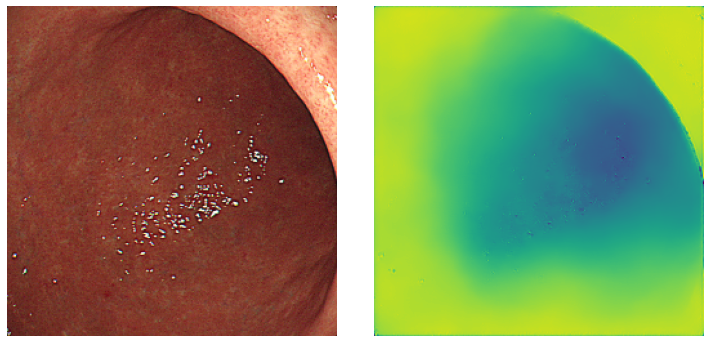

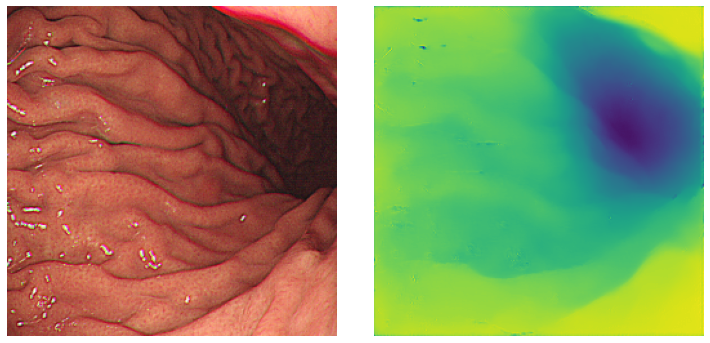

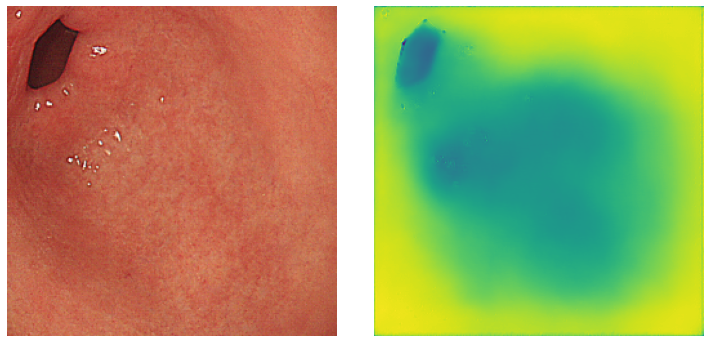

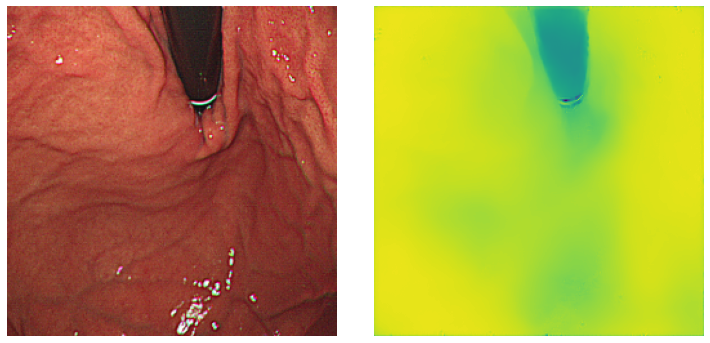

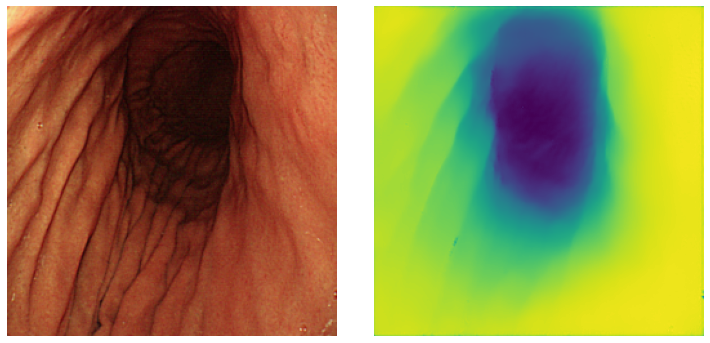

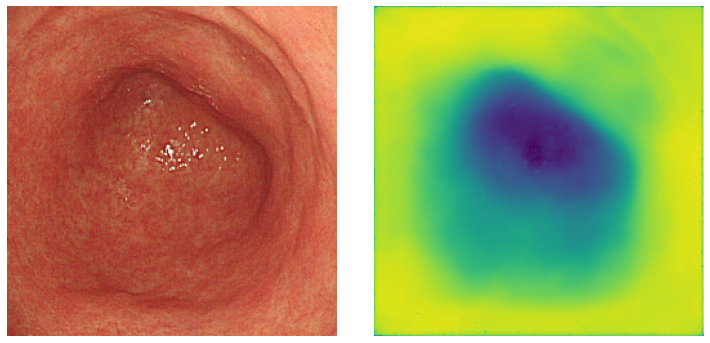

In [47]:
for i in range(7):
    i = random.randint(0, 1030)
    plt.figure(figsize=(10, 10))
    plt.subplot(121)
    plt.imshow(all_img[i])
    plt.tight_layout()
    plt.axis('off')
    plt.subplot(122)
    plt.imshow(predict_imgs[i,...,0])
    plt.tight_layout()
    plt.axis('off')

    plt.show()